In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
stock_data = pd.read_csv('datasets/merged_stock_data.csv')

#Mag 7 list
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'META', 'TSLA', 'NVDA']
#company_list = [AAPL, GOOG, MSFT, AMZN, META, TSLA, NVDA]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "META", "TESLA", "NVIDIA"]


stock_data.head()

company_name                       Date   Open   High    Low  Close  \
0         AAPL  2012-03-14 00:00:00+00:00  20.64  21.24  20.55  21.06   
1         AAPL  2012-03-15 00:00:00+00:00  21.41  21.43  20.66  20.91   
2         AAPL  2012-03-16 00:00:00+00:00  20.88  21.04  20.64  20.91   
3         AAPL  2012-03-19 00:00:00+00:00  21.37  21.49  21.04  21.47   
4         AAPL  2012-03-20 00:00:00+00:00  21.41  21.67  21.12  21.64   

   Adj Close      Volume  20EMA  50SMA    RSI    VIX  
0      17.78  1418844000  19.04  17.15  85.52  15.31  
1      17.66  1159718000  19.21  17.27  81.25  15.42  
2      17.66   825487600  19.38  17.39  80.61  14.47  
3      18.13   901236000  19.58  17.52  81.71  15.04  
4      18.28   816662000  19.77  17.65  81.32  15.58

In [8]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44323 entries, 0 to 44322
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  44323 non-null  object 
 1   Date          44323 non-null  object 
 2   Open          44323 non-null  float64
 3   High          44323 non-null  float64
 4   Low           44323 non-null  float64
 5   Close         44323 non-null  float64
 6   Adj Close     44323 non-null  float64
 7   Volume        44323 non-null  int64  
 8   20EMA         44323 non-null  float64
 9   50SMA         44323 non-null  float64
 10  RSI           44323 non-null  float64
 11  VIX           44323 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 4.1+ MB


In [9]:
stock_data.isnull().sum()

company_name    0
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
20EMA           0
50SMA           0
RSI             0
VIX             0
dtype: int64

In [10]:
stock_data.duplicated().sum().any()

True

In [11]:
# Drop duplicates and keep the last occurrence
stock_data = stock_data.drop_duplicates(keep='last')


In [12]:
stock_data.duplicated().sum().any()

False

In [13]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22188 entries, 809 to 44322
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  22188 non-null  object 
 1   Date          22188 non-null  object 
 2   Open          22188 non-null  float64
 3   High          22188 non-null  float64
 4   Low           22188 non-null  float64
 5   Close         22188 non-null  float64
 6   Adj Close     22188 non-null  float64
 7   Volume        22188 non-null  int64  
 8   20EMA         22188 non-null  float64
 9   50SMA         22188 non-null  float64
 10  RSI           22188 non-null  float64
 11  VIX           22188 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 2.2+ MB


In [14]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [15]:
stock_data.head()

company_name                      Date    Open    High     Low   Close  \
809          AAPL 2015-06-03 00:00:00+00:00   32.67   32.74   32.47   32.53   
1795         AAPL 2019-05-03 00:00:00+00:00   52.72   52.96   52.56   52.94   
2427         AAPL 2021-11-03 00:00:00+00:00  150.39  151.97  149.82  151.49   
3177         AAPL 2024-10-29 00:00:00+00:00  233.10  234.33  232.32  233.67   
3178         AAPL 2024-10-30 00:00:00+00:00  232.61  233.47  229.55  230.10   

      Adj Close     Volume   20EMA   50SMA    RSI    VIX  
809       29.25  123934000   32.41   31.94  63.48  13.66  
1795      50.83   83569600   50.72   47.80  71.57  12.87  
2427     149.00   54511500  148.12  147.42  72.00  15.10  
3177     233.67   35417200  230.95  227.10  58.58  19.34  
3178     230.10   47070900  230.87  227.18  51.95  20.35

In [16]:
stock_data.company_name.unique()

array(['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA'],
      dtype=object)

In [60]:
stock_data.describe()

Open          High           Low         Close     Adj Close  \
count  10290.000000  10290.000000  10290.000000  10290.000000  10290.000000   
mean     159.707564    161.857815    157.536490    159.754371    158.651197   
std      108.545577    109.848851    107.142531    108.511681    108.023068   
min        3.270000      3.380000      3.190000      3.200000      3.170000   
25%       84.997500     86.400000     83.627500     84.837500     84.697500   
50%      146.910000    148.685000    145.175000    146.955000    145.650000   
75%      215.147500    218.735000    212.452500    216.005000    213.962500   
max      600.980000    602.950000    589.960000    595.940000    595.940000   

             Volume         20EMA         50SMA           RSI           VIX  
count  1.029000e+04  10290.000000  10290.000000  10290.000000  10290.000000  
mean   1.182370e+08    158.345081    156.182644     54.971536     20.530762  
std    1.650747e+08    107.295608    105.765335     16.789358      7.993220  
min    5.467500e+06      3.540000      3.630000      3.140000     11.540000  
25%    2.515028e+07     82.262500     79.147500     42.750000     15.000000  
50%    5.476660e+07    145.985000    144.620000     55.680000     18.705000  
75%    1.157953e+08    215.100000    212.045000     67.590000     23.760000  
max    2.511528e+09    577.180000    556.120000     97.530000     82.690000

In [17]:
#plotting the distribution
def plot_adj_close_boxplot(data_fs):
    num_cols = data_fs['company_name'].unique()  # Get unique tickers
    
    fig = make_subplots(rows=1, cols=len(num_cols), 
                        subplot_titles=num_cols, 
                        vertical_spacing=0.2)

    for i, ticker in enumerate(num_cols):
        fig.add_trace(go.Box(y=data_fs[data_fs['company_name'] == ticker]['Adj Close'], 
                             name=ticker), row=1, col=i+1)

    fig.update_layout(height=400, width=1200, showlegend=False, 
                      title_text=f'Box Plots of Adj Close Prices')
    
    fig.show()


plot_adj_close_boxplot(stock_data)

In [18]:
def remove_outliers_iqr(data_fs):
    # Create a copy of the DataFrame to avoid modifying the original
    data_cleaned = data_fs.copy()
    
    num_cols = data_cleaned['company_name'].unique()  # Get unique tickers
    
    # Loop through each company to identify and remove outliers
    for ticker in num_cols:
        y_data = data_cleaned[data_cleaned['company_name'] == ticker]['Adj Close']
        
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = y_data.quantile(0.25)
        Q3 = y_data.quantile(0.75)
        IQR = Q3 - Q1  # Calculate IQR
        
        # Define the boundaries for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter the DataFrame to remove outliers
        data_cleaned = data_cleaned[(data_cleaned['company_name'] != ticker) | 
                                     ((y_data >= lower_bound) & (y_data <= upper_bound))]

    return data_cleaned

def plot_adj_close_boxplot(data_fs):
    # Remove outliers from the data using IQR method
    data_cleaned = remove_outliers_iqr(data_fs)
    num_cols = data_cleaned['company_name'].unique()  # Get unique tickers
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta']  # Define a color palette
    
    # Create subplots
    fig = make_subplots(rows=1, cols=len(num_cols), 
                        subplot_titles=num_cols, 
                        vertical_spacing=0.2)

    for i, ticker in enumerate(num_cols):
        # Add a box trace for each company without outliers
        fig.add_trace(go.Box(y=data_cleaned[data_cleaned['company_name'] == ticker]['Adj Close'], 
                             name=ticker,
                             marker_color=colors[i % len(colors)],
                             boxmean='sd'),  # Show mean and standard deviation
                      row=1, col=i+1)

    # Update layout for aesthetics
    fig.update_layout(height=400, width=1200, showlegend=False, 
                      title_text='Box Plots of Adjusted Close Prices (Without Outliers)',
                      title_x=0.5)  # Center the title
    
    # Show the plot
    fig.show()

# Call the function with your original stock_data
plot_adj_close_boxplot(stock_data)


In [19]:
def plot_adj_close_histogram(data_fs):
    num_cols = data_fs['company_name'].unique()  # Get unique tickers
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta']  # Define a color palette

    # Create subplots
    fig = make_subplots(rows=1, cols=len(num_cols), 
                        subplot_titles=num_cols, 
                        vertical_spacing=0.2)

    for i, ticker in enumerate(num_cols):
        # Add a histogram trace for each company
        fig.add_trace(go.Histogram(x=data_fs[data_fs['company_name'] == ticker]['Adj Close'], 
                                     name=ticker,
                                     marker_color=colors[i % len(colors)],
                                     opacity=0.75,
                                     nbinsx=20),  # You can adjust the number of bins
                      row=1, col=i+1)

    # Update layout for aesthetics
    fig.update_layout(height=400, width=1200, showlegend=False, 
                      title_text='Histograms of Adjusted Close Prices',
                      title_x=0.5)  # Center the title
    
    # Show the plot
    fig.show()

# Call the function with your original stock_data
plot_adj_close_histogram(stock_data)


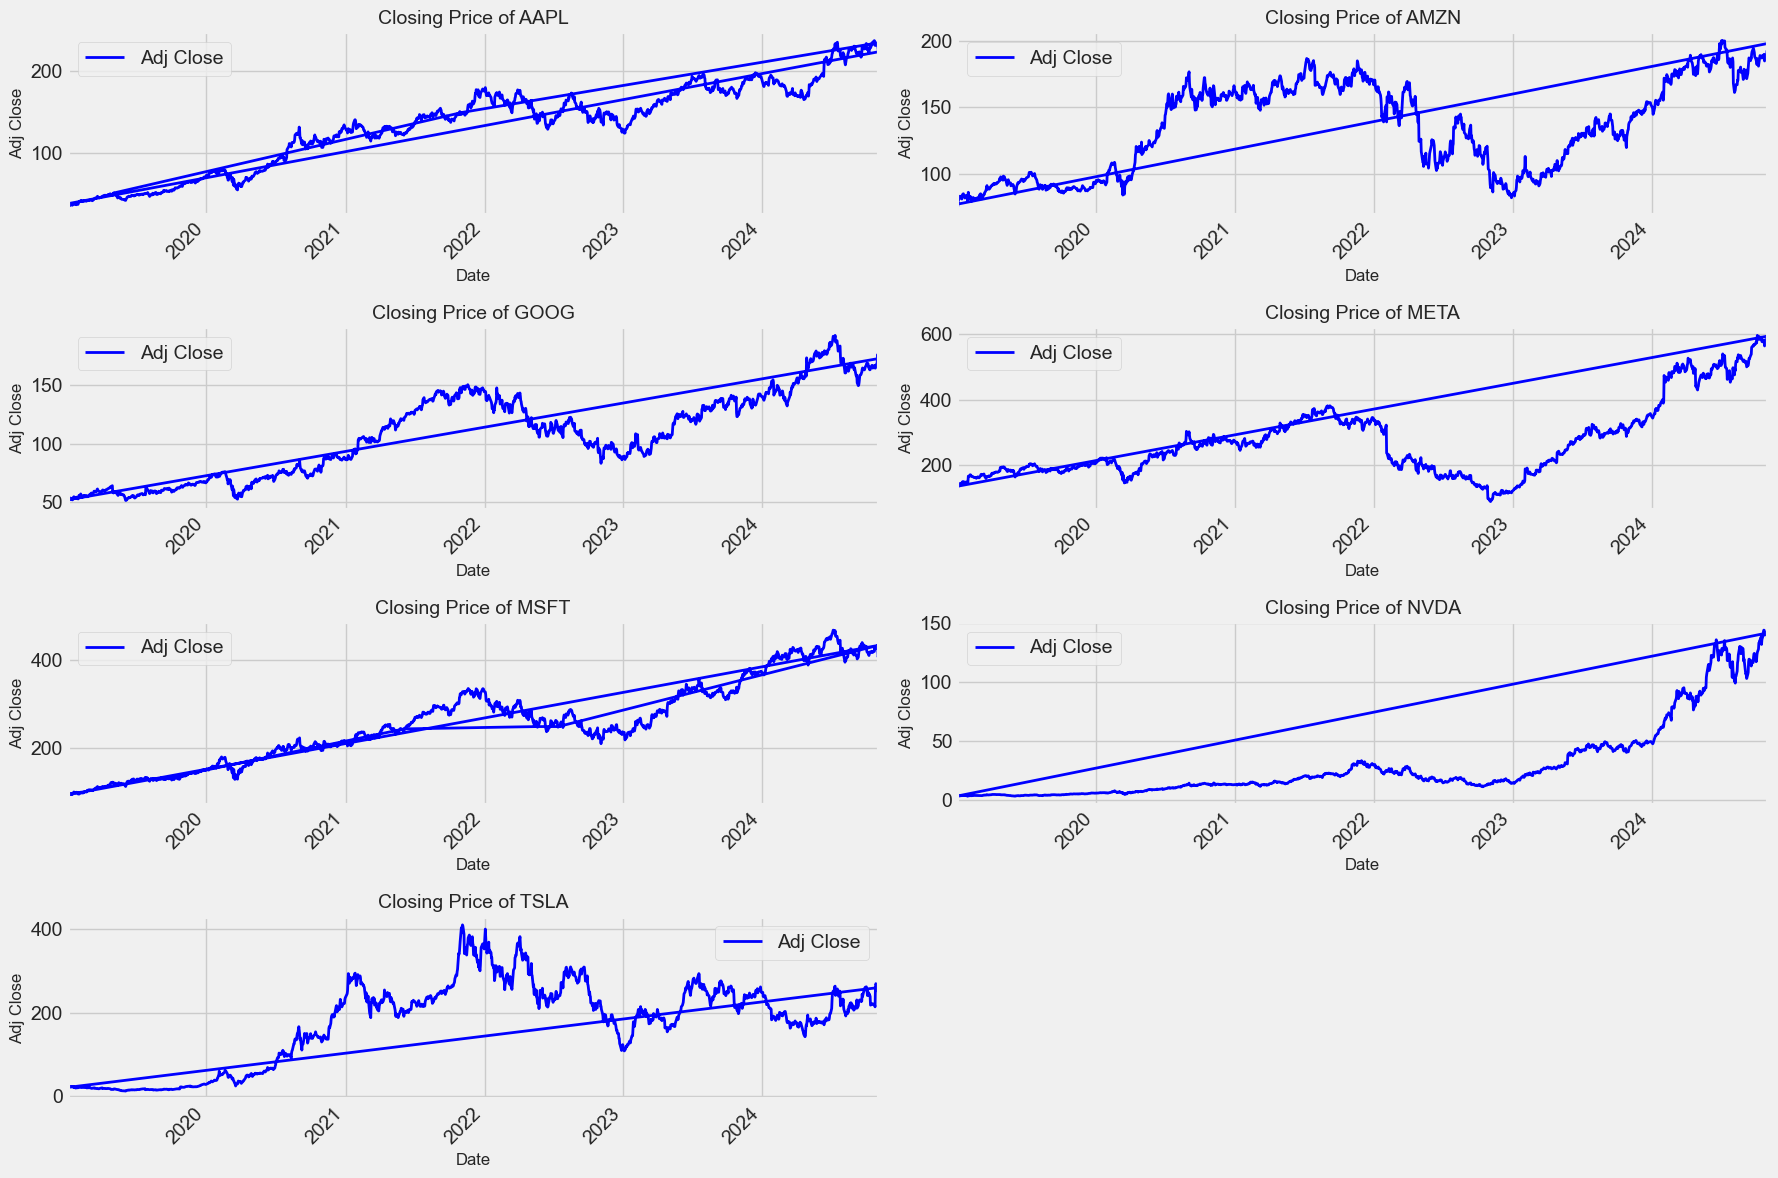

In [20]:
stock_data = stock_data[stock_data['Date'] >= '2019-01-01']

company_name = stock_data['company_name'].unique()

# Set the number of subplots based on the number of companies
num_companies = len(company_name)
cols = 2  # Number of columns in the subplot grid
rows = (num_companies + cols - 1) // cols  # Calculate rows needed

# Create the figure for the subplots
plt.figure(figsize=(18, 12))  # Increased figure size for better visibility
plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)  # Adjusted layout

for i, company in enumerate(company_name):
    # Filter data for the current company
    company_data = stock_data[stock_data['company_name'] == company]
    
    # Create a subplot for each company
    plt.subplot(rows, cols, i + 1)
    
    # Plotting the line graph for Adjusted Close prices
    plt.plot(company_data['Date'], company_data['Adj Close'], label='Adj Close', color='blue', linewidth=2)  # Line plot
    plt.ylabel('Adj Close', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.title(f"Closing Price of {company}", fontsize=14)

    # Format x-axis labels to show dates correctly
    plt.xticks(rotation=45, ha='right')  # Rotated and aligned x-axis labels for better readability
    plt.gca().xaxis_date()  # Automatically format x-axis as dates
    plt.gca().margins(x=0)  # Remove margins on x-axis for better fit
    plt.grid(True)  # Added grid for better readability
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

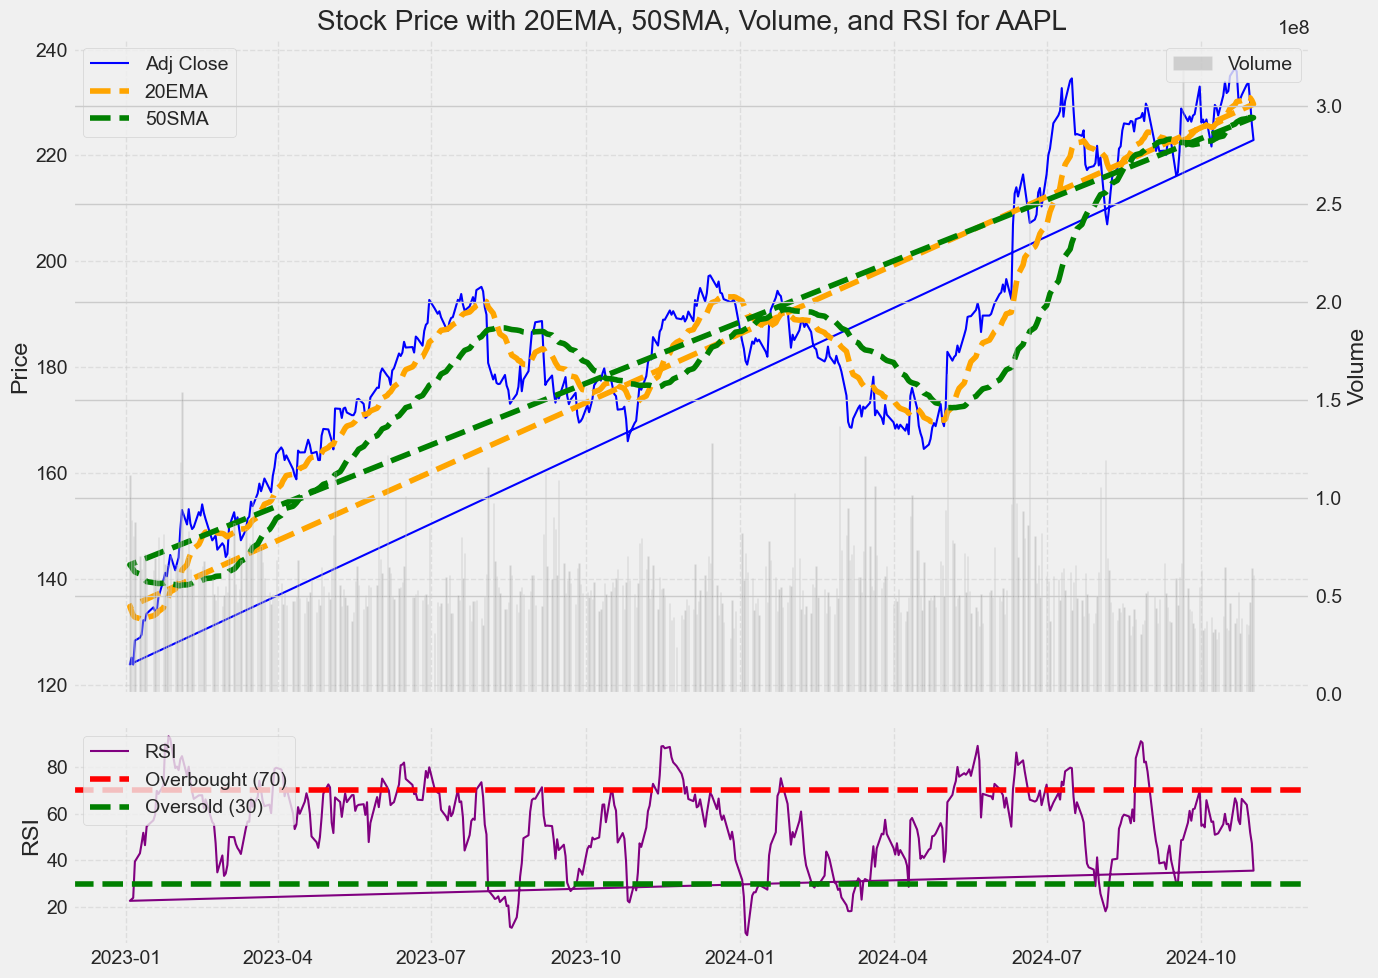

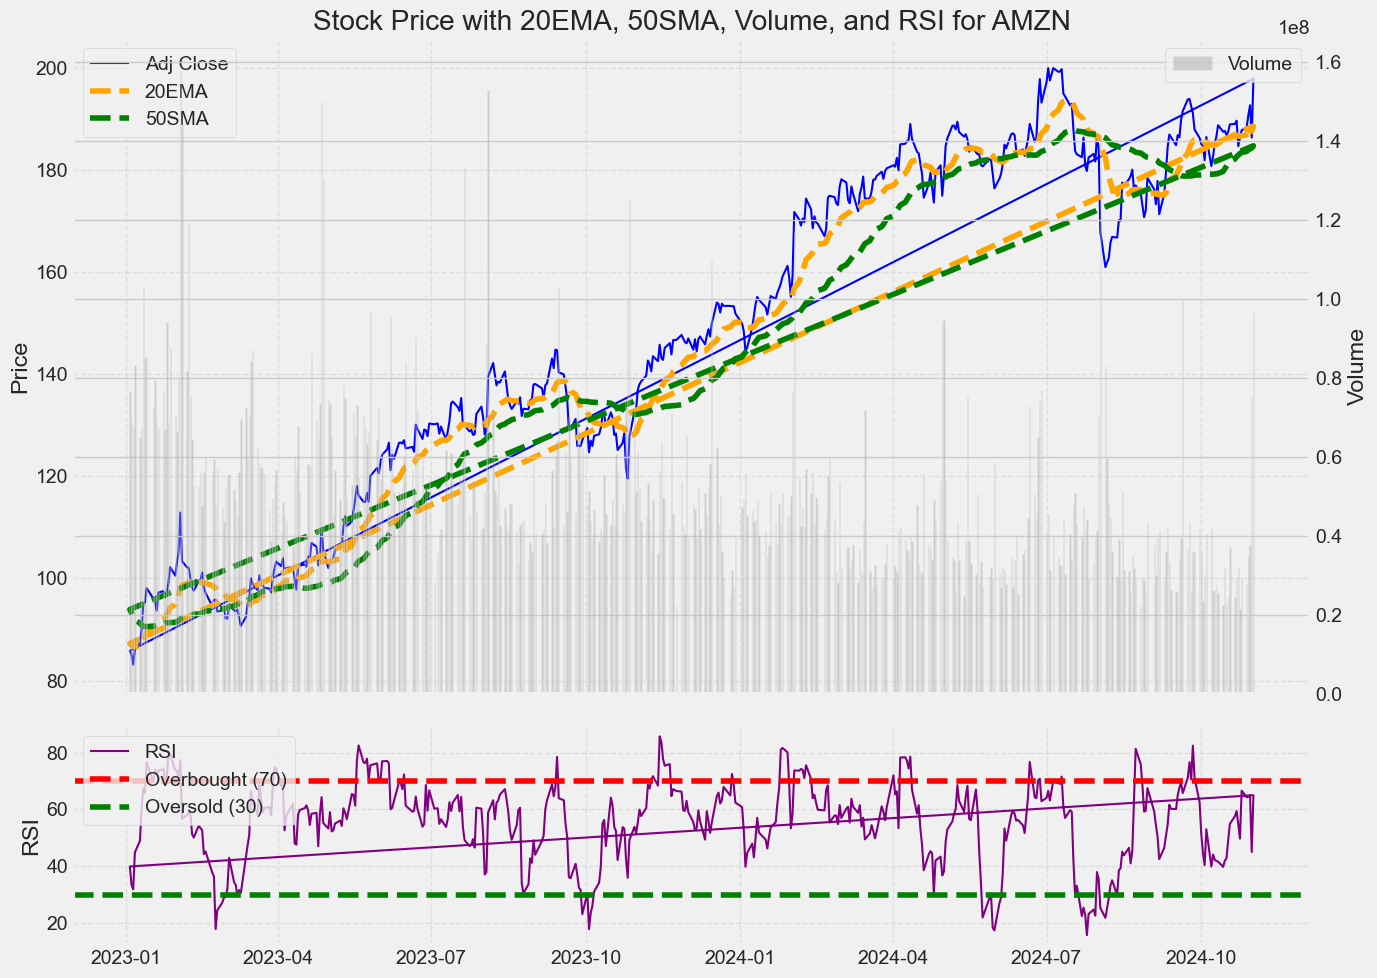

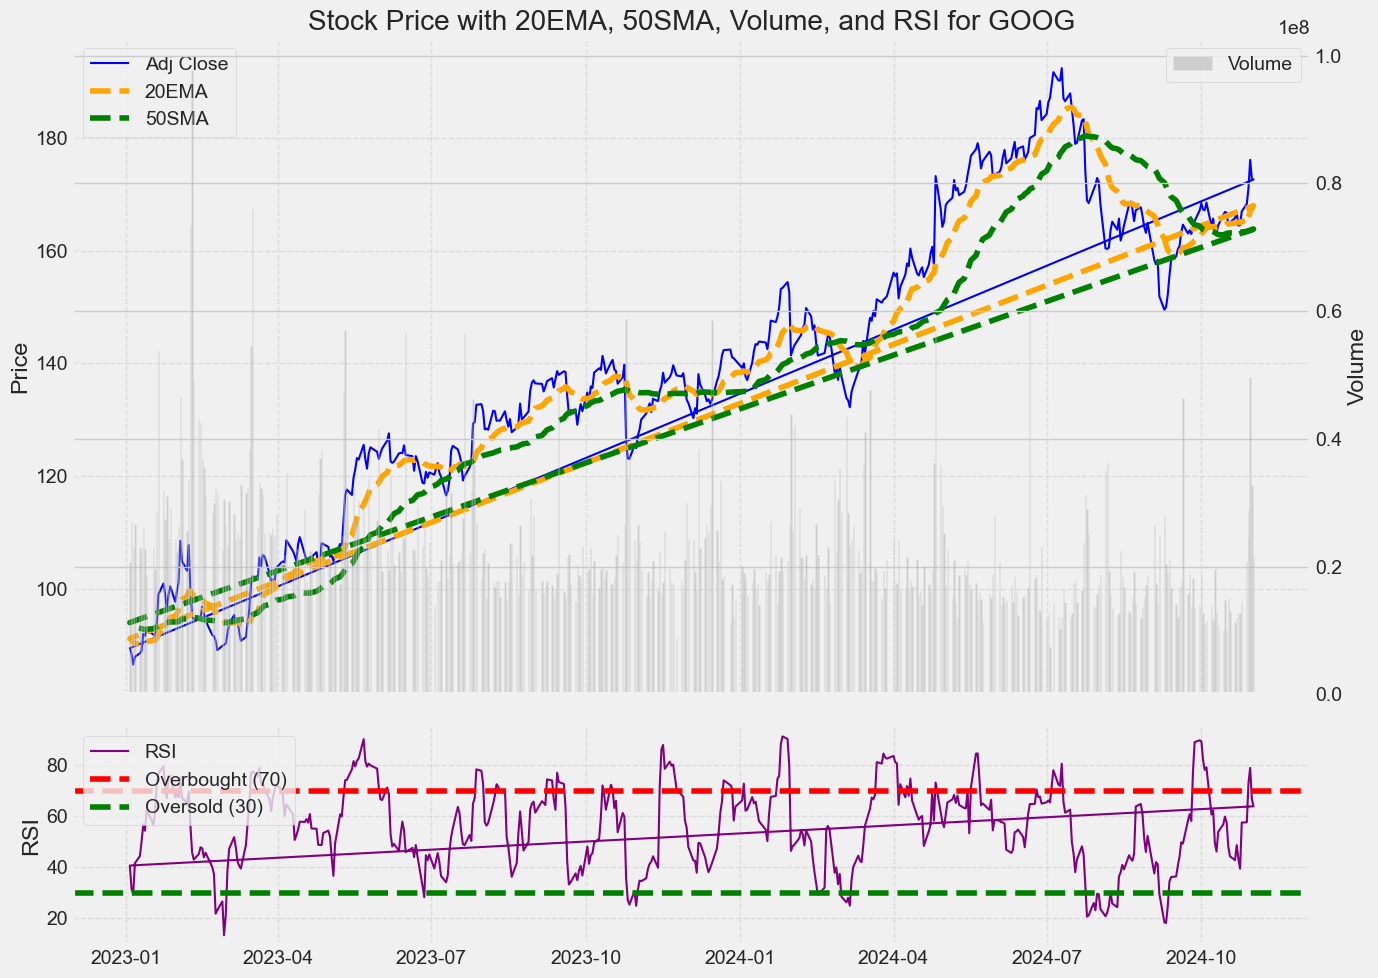

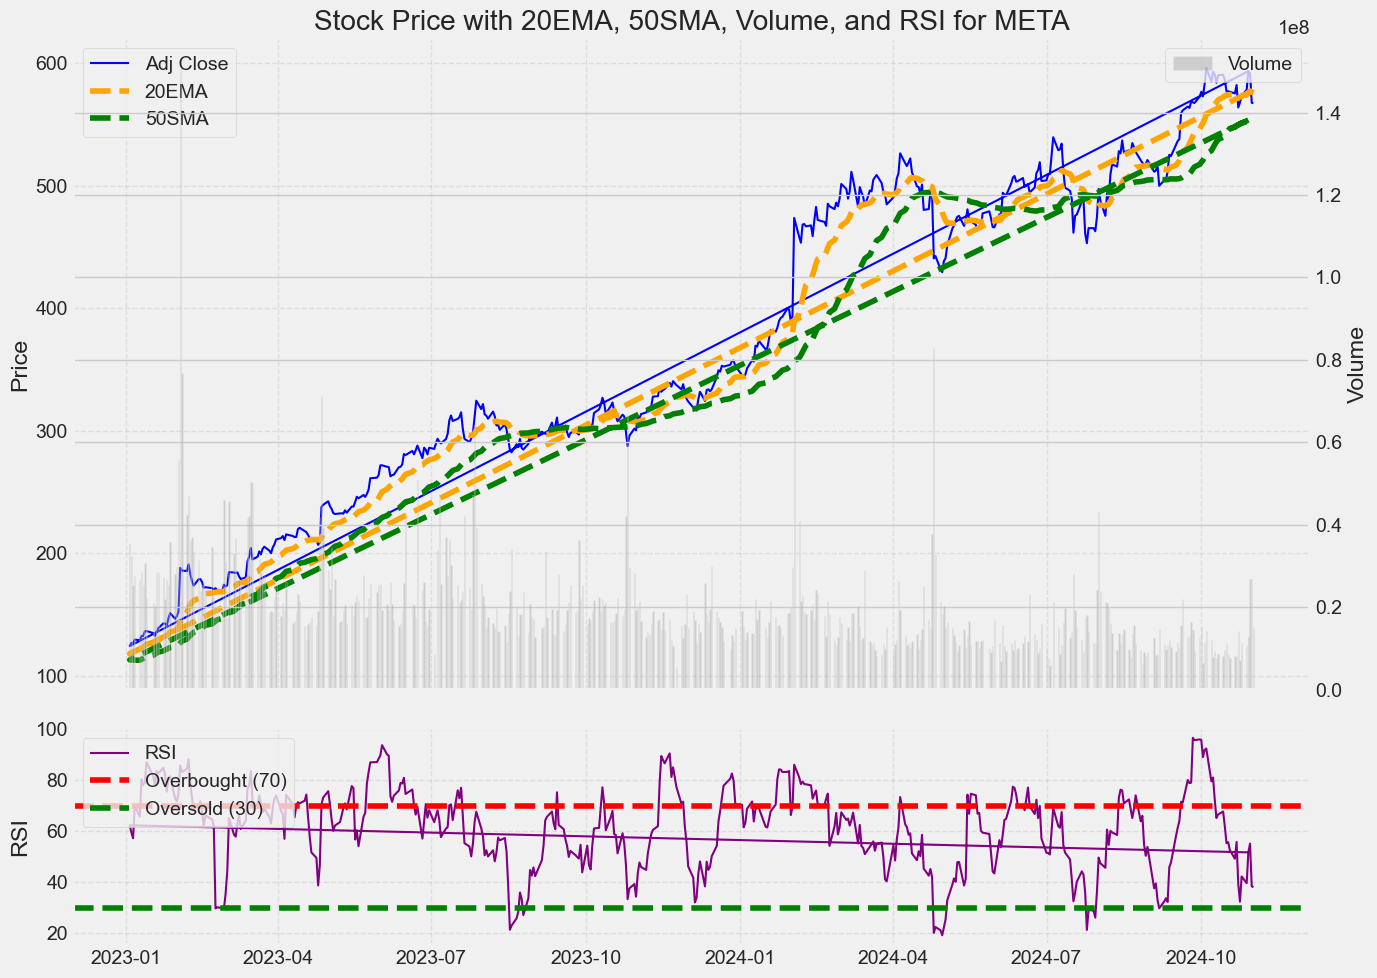

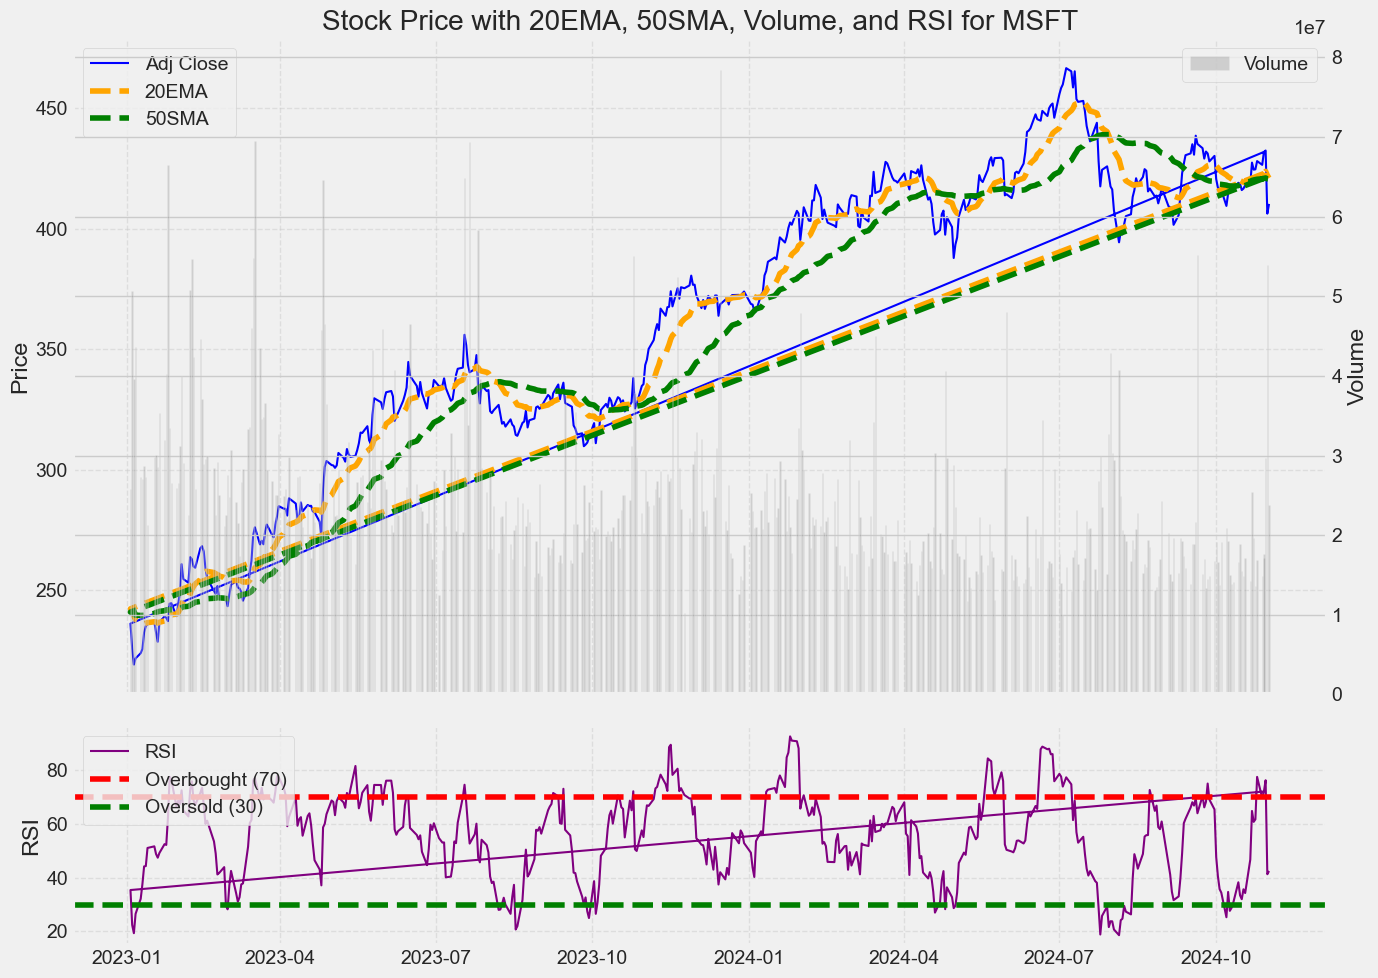

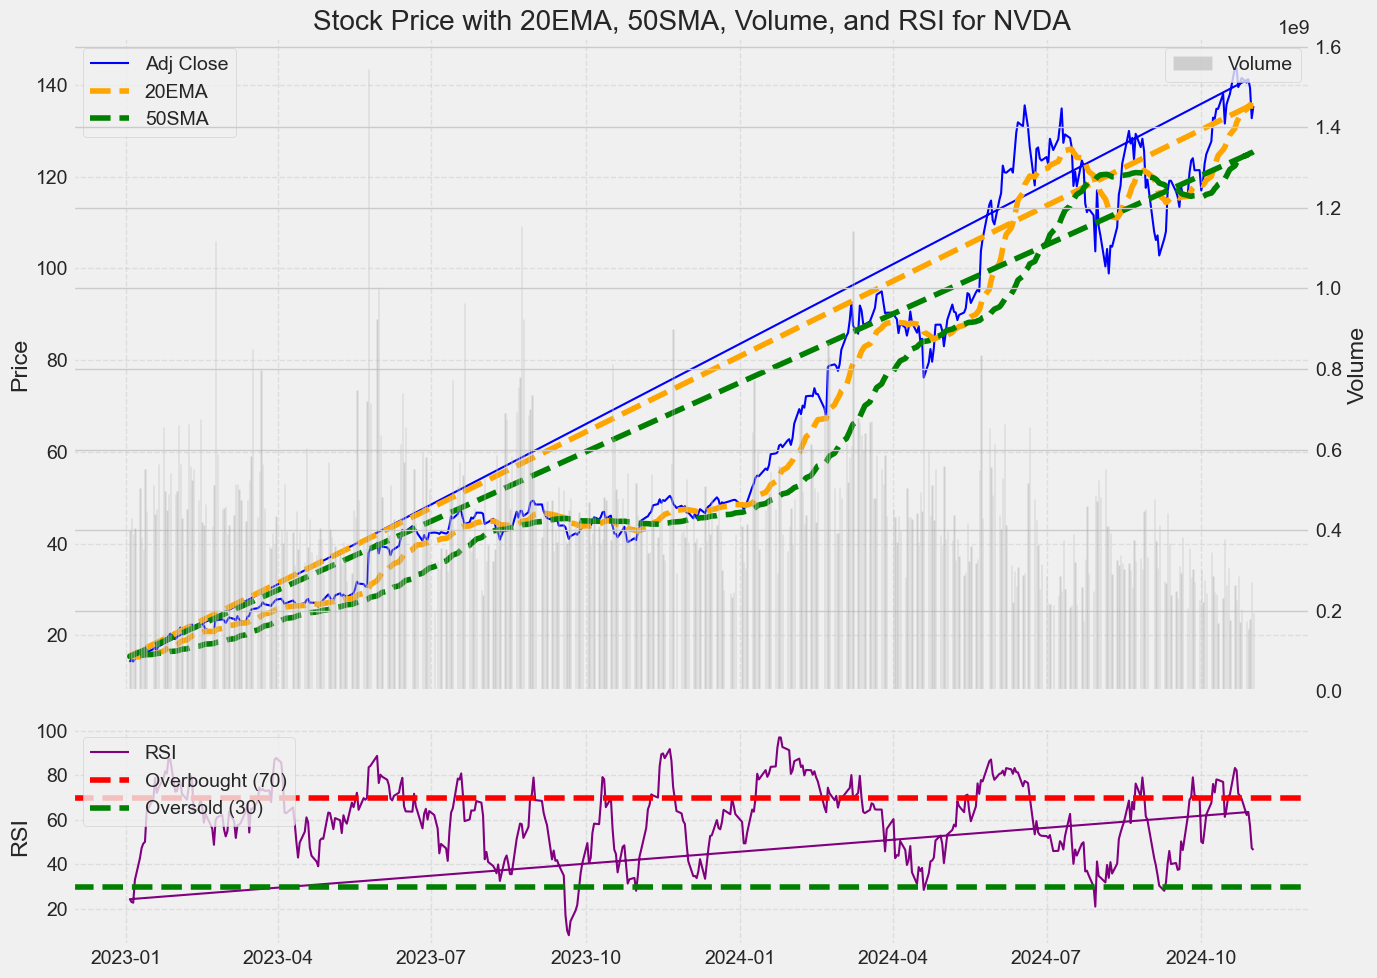

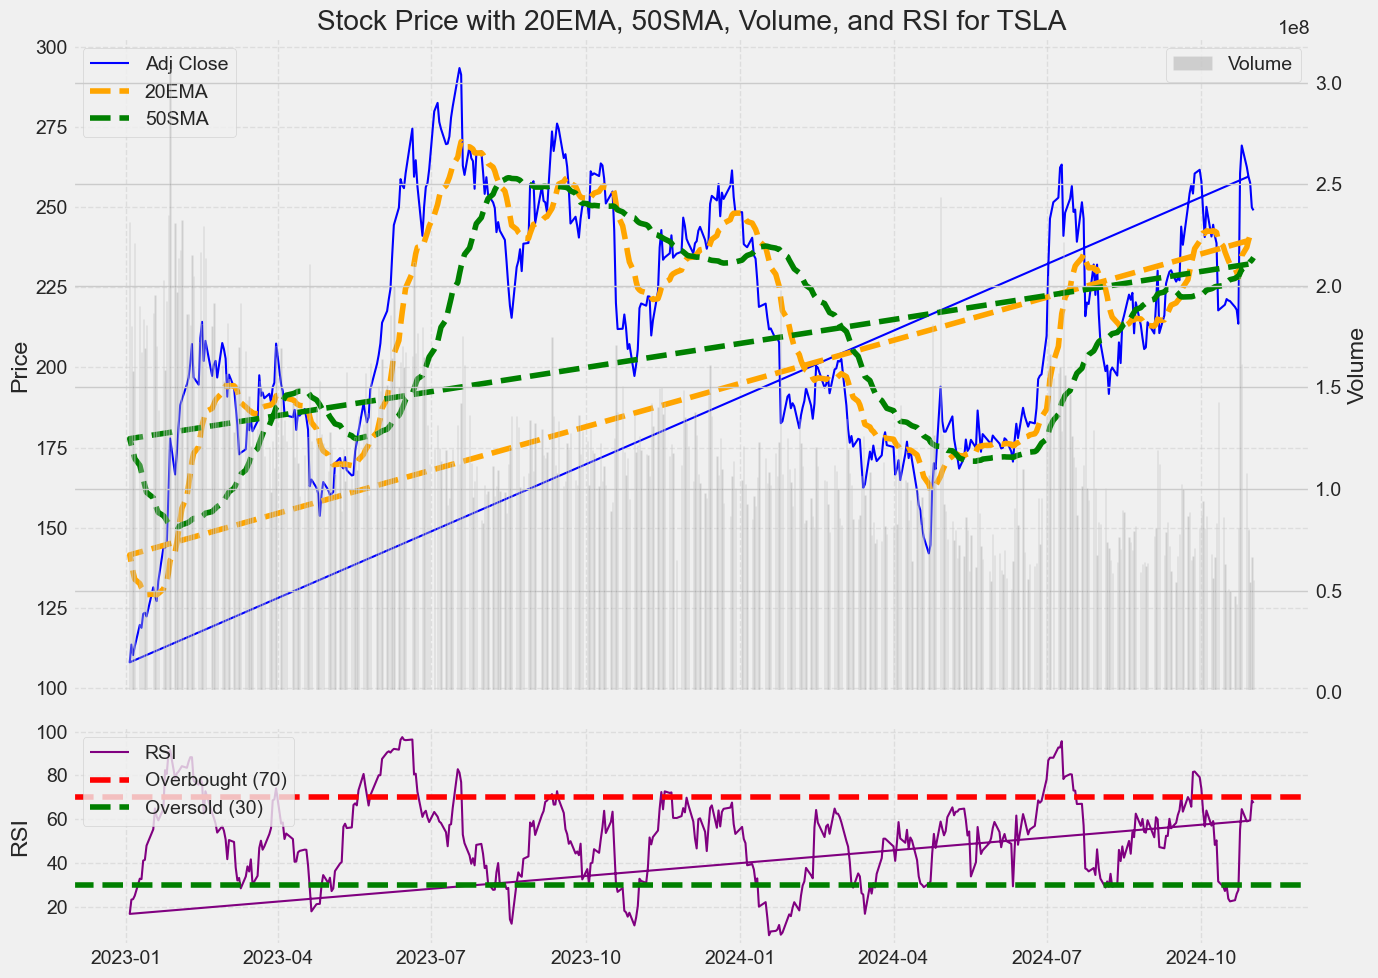

In [21]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# List of unique company tickers
tickers = stock_data['company_name'].unique()

# Loop through each ticker and create a separate plot with RSI as a subplot
for ticker in tickers:
    # Filter data for the current ticker and date range
    ticker_data = stock_data[(stock_data['company_name'] == ticker) & 
                             (stock_data['Date'] >= '2023-01-01') & 
                             (stock_data['Date'] <= '2024-12-31')]

    # Set up figure with two subplots: Price and RSI
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Plot Adj Close, 20EMA, and 50SMA as line charts on the main axis (ax1)
    ax1.plot(ticker_data['Date'], ticker_data['Adj Close'], label='Adj Close', color='blue', linewidth=1.5)
    ax1.plot(ticker_data['Date'], ticker_data['20EMA'], label='20EMA', color='orange', linestyle='--')
    ax1.plot(ticker_data['Date'], ticker_data['50SMA'], label='50SMA', color='green', linestyle='--')

    # Create a secondary y-axis for Volume on ax1
    ax3 = ax1.twinx()  # Create a twin axis for volume
    ax3.bar(ticker_data['Date'], ticker_data['Volume'], color='grey', alpha=0.3, label='Volume', width=0.8)

    # Set labels and title for the main subplot (price and volume)
    ax1.set_ylabel('Price')
    ax3.set_ylabel('Volume')
    ax1.set_title(f'Stock Price with 20EMA, 50SMA, Volume, and RSI for {ticker}')

    # Set x-axis format and rotation for readability
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax1.grid(visible=True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)

    # Show legends
    ax1.legend(loc='upper left')
    ax3.legend(loc='upper right')

    # Plot the RSI on the second axis (ax2)
    ax2.plot(ticker_data['Date'], ticker_data['RSI'], label='RSI', color='purple', linewidth=1.5)
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    ax2.grid(visible=True, linestyle='--', alpha=0.5)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

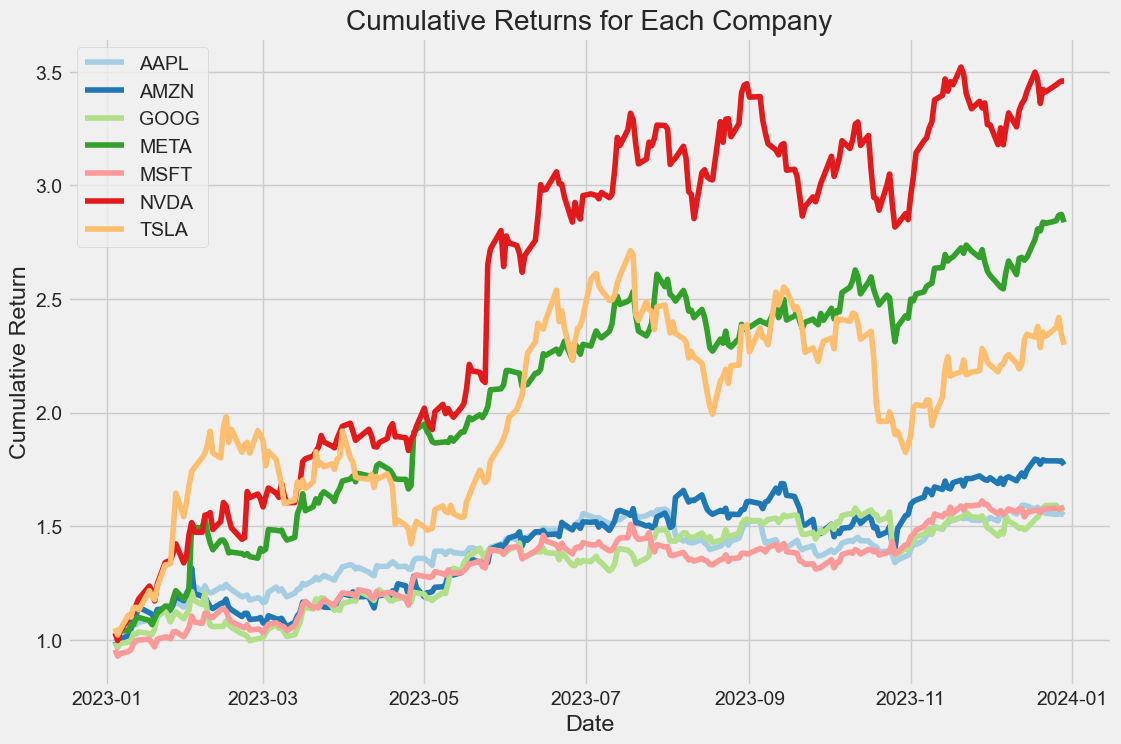

In [22]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

filtered_data = stock_data[stock_data['Date'] >= '2023-01-01']
filtered_data = filtered_data[filtered_data['Date'] <= '2024-01-01']

filtered_data.loc[:, 'Daily Return'] = filtered_data.groupby('company_name')['Adj Close'].pct_change()
filtered_data['Cumulative Return'] = (1 + filtered_data['Daily Return']).groupby(filtered_data['company_name']).cumprod()

colors = sns.color_palette("Paired", len(company_name))

plt.figure(figsize=(12, 8))
for i, company in enumerate(company_name):
    company_data = filtered_data[filtered_data['company_name'] == company]
    plt.plot(company_data['Date'], company_data['Cumulative Return'], label=company, color=colors[i])

plt.title("Cumulative Returns for Each Company")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

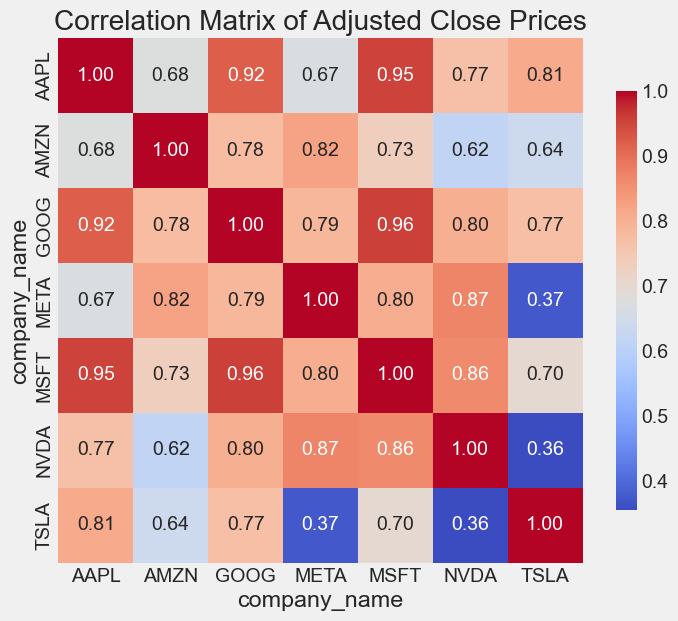

In [59]:
# Identify and resolve duplicates
stock_data = stock_data.drop_duplicates(subset=['Date', 'company_name'])

# Alternatively, aggregate duplicate rows by taking their mean
# stock_data = stock_data.groupby(['Date', 'company_name'], as_index=False).mean()

# Ensure data consistency
assert not stock_data.duplicated(subset=['Date', 'company_name']).any(), "Duplicates still exist!"

# Create pivot tables
adj_close_matrix = stock_data.pivot(index='Date', columns='company_name', values='Adj Close')
#daily_return_matrix = stock_data.pivot(index='Date', columns='company_name', values='Daily Return')

# Calculate correlation matrices
adj_close_corr = adj_close_matrix.corr()
#daily_return_corr = daily_return_matrix.corr()

# Plot correlation matrices
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(adj_close_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Adjusted Close Prices")



plt.tight_layout()
plt.show()


In [33]:
apple_data = stock_data[stock_data['company_name'] == 'AAPL']  # Replace 'AAPL' with Apple ticker if different
#apple_data.isna().sum()
apple_data = apple_data.dropna()
apple_data["Date"] = pd.to_datetime(apple_data["Date"])
apple_data = apple_data.sort_values("Date").reset_index(drop=True)

apple_data.head()


company_name                      Date   Open   High    Low  Close  \
0         AAPL 2019-01-02 00:00:00+00:00  38.72  39.71  38.56  39.48   
1         AAPL 2019-01-03 00:00:00+00:00  35.99  36.43  35.50  35.55   
2         AAPL 2019-01-04 00:00:00+00:00  36.13  37.14  35.95  37.06   
3         AAPL 2019-01-07 00:00:00+00:00  37.17  37.21  36.47  36.98   
4         AAPL 2019-01-08 00:00:00+00:00  37.39  37.96  37.13  37.69   

   Adj Close     Volume  20EMA  50SMA    RSI    VIX  
0      37.75  148158800  40.98  46.27  37.78  23.22  
1      33.99  365248800  40.46  45.88  27.23  25.45  
2      35.44  234428400  40.14  45.52  32.08  21.38  
3      35.36  219111200  39.84  45.14  34.91  21.40  
4      36.04  164101200  39.63  44.82  38.91  20.47

In [34]:
import math
data = apple_data.filter(['Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
#training_data_len = int(np.ceil( len(dataset) * .80 ))
training_data_len = math.ceil(len(dataset)*0.8)
print(dataset)


training_data_len

[[ 37.75]
 [ 33.99]
 [ 35.44]
 ...
 [230.1 ]
 [225.91]
 [222.91]]


1176

In [35]:
# features = ["Adj Close", "Volume", "20EMA", "50SMA", "RSI", "VIX", "Daily Return"]
# data_values = apple_data[features].values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01856882],
       [0.        ],
       [0.00716085],
       ...,
       [0.96849227],
       [0.94779989],
       [0.93298434]])

In [ ]:
import pickle
# Save the scaler to a pickle file
scaler_filename = 'model/scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

In [36]:
#Creating training dataset
train_data = scaled_data[0:training_data_len,:]
X_train = []
y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(X_train)
        print(y_train)
        print()

[array([0.01856882, 0.        , 0.00716085, 0.00676577, 0.01012396,
       0.01313645, 0.01372907, 0.01190182, 0.00923502, 0.01284014,
       0.01506247, 0.01614895, 0.0172848 , 0.01313645, 0.01382784,
       0.01239567, 0.01837128, 0.0166428 , 0.01476616, 0.02721122,
       0.02864339, 0.02874216, 0.03432268, 0.03777964, 0.03782903,
       0.0339276 , 0.03417453, 0.03303867, 0.03476715, 0.0339276 ,
       0.03461899, 0.03417453, 0.03481653, 0.03610055, 0.03496469,
       0.03723641, 0.03871796, 0.03881673, 0.03945874, 0.03743395,
       0.03960689, 0.04064398, 0.0402489 , 0.03906366, 0.03664378,
       0.03713764, 0.0442491 , 0.04661959, 0.0475579 , 0.04997778,
       0.05279273, 0.05506445, 0.05328658, 0.0552126 , 0.06345992,
       0.05866956, 0.055904  , 0.05358289, 0.05560768, 0.055904  ])]
[0.057336164748876484]



In [37]:
#converting into numpy arrays
X_train, y_train = np.array(X_train),np.array(y_train)
#reshape the data
X_train =np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1116, 60, 1)

In [ ]:
# model = Sequential()

# # Add the first LSTM layer with Dropout regularization
# model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))

# # Add the second LSTM layer with Dropout regularization
# model.add(LSTM(50, return_sequences=False))  # return_sequences=False since this is the last LSTM layer
# model.add(Dropout(0.2))

# # Add the Dense layer with 25 units
# model.add(Dense(25))

# # Add the final output layer with 1 unit
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer="adam", loss="mean_squared_error")


c:\Users\sunil\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [39]:
from tensorflow.keras.optimizers import Adam

# Define the model
def build_model(hp):
    model = Sequential()
    
    # LSTM layer with tunable units
    model.add(LSTM(
        units=hp.Int("units", min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    
    # Second LSTM layer with tunable dropout
    model.add(LSTM(units=hp.Int("units_2", min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dropout(hp.Float("dropout", 0.1, 0.5, step=0.1)))
    
    # Dense layers
    model.add(Dense(units=hp.Int("dense_units", min_value=10, max_value=50, step=10)))
    model.add(Dense(1))
    
    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])
        ),
        loss="mean_squared_error"
    )
    return model


In [ ]:
# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuning_dir",
    project_name="lstm_stock_price"
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


Trial 10 Complete [00h 00m 34s]
val_loss: 0.00040126388194039464

Best val_loss So Far: 0.0002961229474749416
Total elapsed time: 00h 06m 07s


In [ ]:
from tensorflow.keras.models import save_model

# Save the model to an HDF5 file
model.save('model/lstm_model.h5')
print("Model saved as lstm_model.h5")


In [57]:
print("Best Hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

Best Hyperparameters:
units: 32
units_2: 96
dropout: 0.1
dense_units: 50
learning_rate: 0.001


In [44]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0607 - val_loss: 0.0017
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 7.3558e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 8.4597e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 9.2850e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 7.0625e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2588e-04 - val_loss: 6.7876e-04
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.9142e-04 - val_loss: 9.5931e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 6.5719e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.6161e-04 - val_loss: 7.2563e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.9852e-04 - val_loss: 5.8148e-04
Epoch 12/50

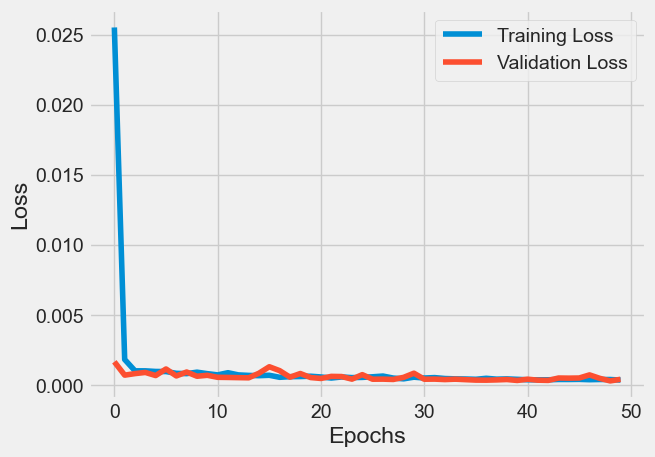

In [45]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#model.fit(X_train,y_train,batch_size=32, epochs=50)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0714
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoc

In [66]:
# test data
test_data =scaled_data[training_data_len-60:,:]
x_test =[]
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    

In [67]:
#shape
x_test =np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [68]:
#predictions
predictions =model.predict(x_test)
predictions =scaler.inverse_transform(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\sunil\AppData\Local\Temp\ipykernel_1760\1964910725.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



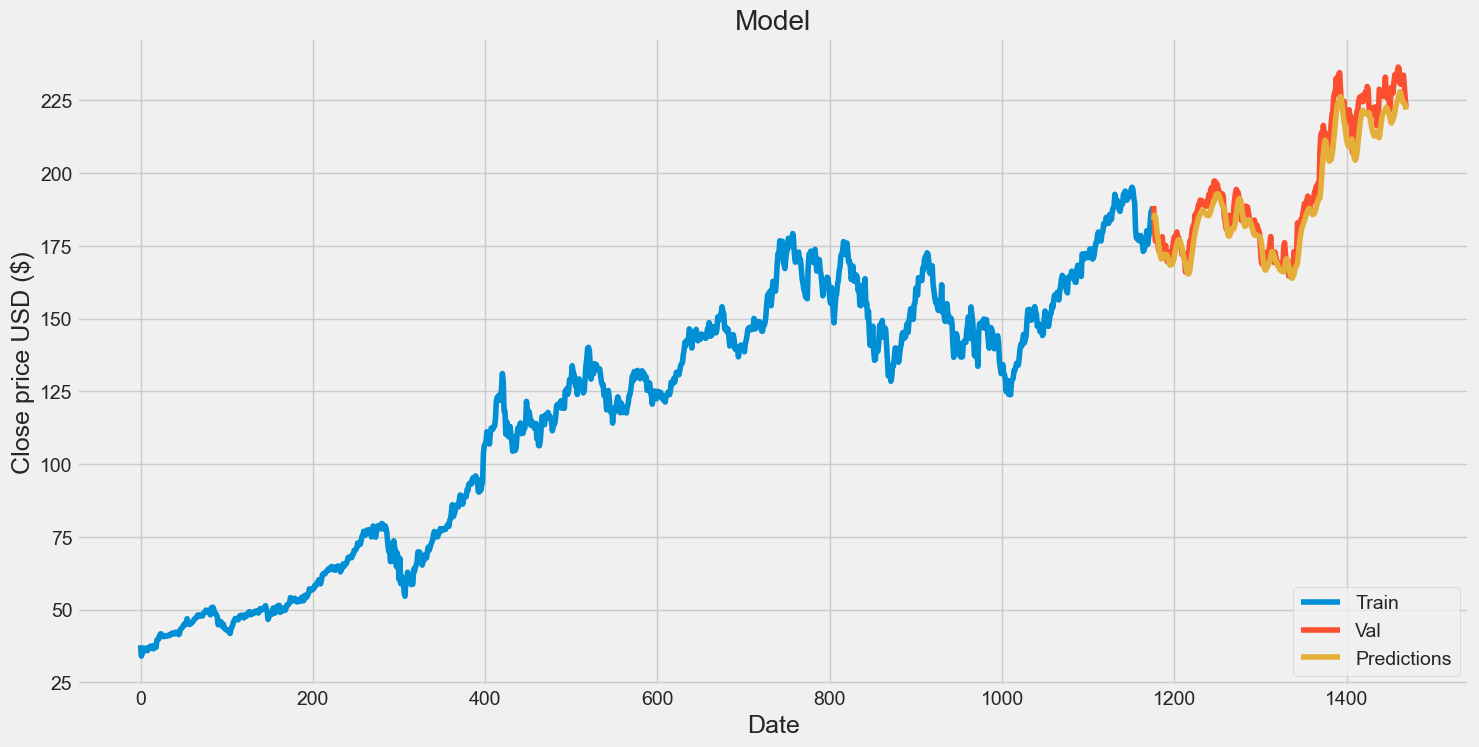

In [69]:
#PLOT
train = data[:training_data_len]
train
valid = data[training_data_len:]
valid['predictions']=predictions
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price USD ($)',fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','predictions']])
plt.legend(['Train','Val','Predictions'],loc ='lower right')
plt.show()

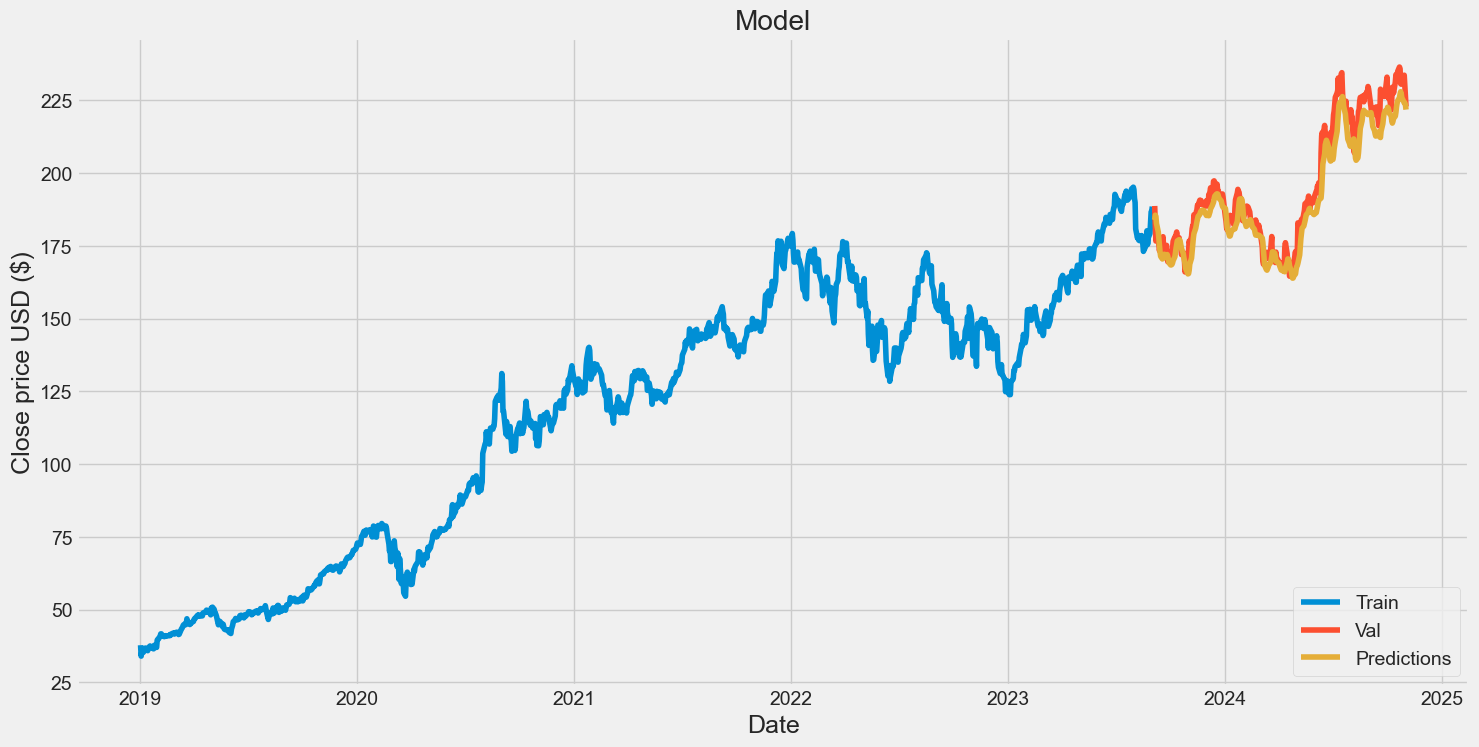

In [54]:
# Prepare valid DataFrame
valid = apple_data.iloc[training_data_len:].copy()  # Retain the original data for validation
valid['Predictions'] = predictions  # Add predictions to valid DataFrame

# PLOT
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.plot(apple_data['Date'][:training_data_len], data['Adj Close'][:training_data_len], label='Train')
plt.plot(apple_data['Date'][training_data_len:], valid['Adj Close'], label='Val')
plt.plot(apple_data['Date'][training_data_len:], valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

Mean Absolute Error: 5.136806376969733


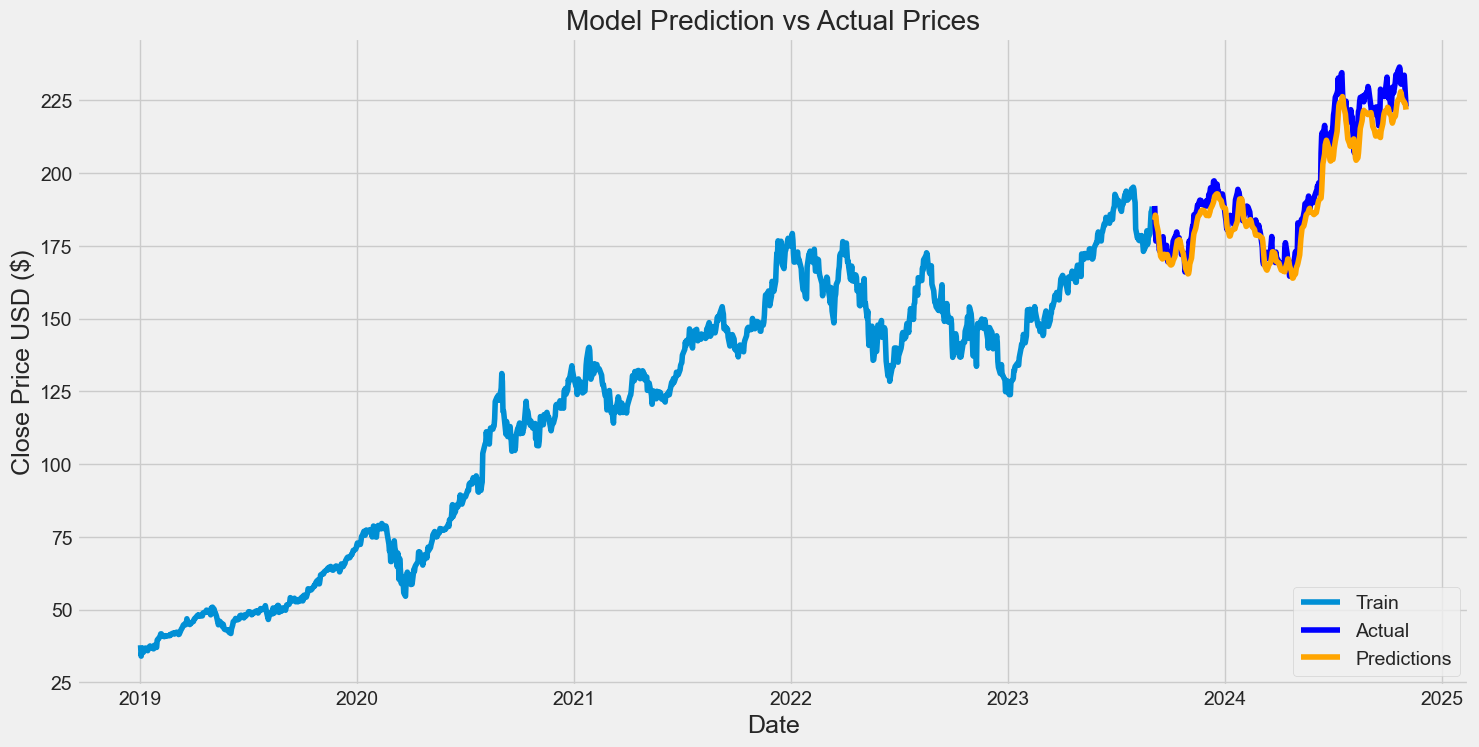

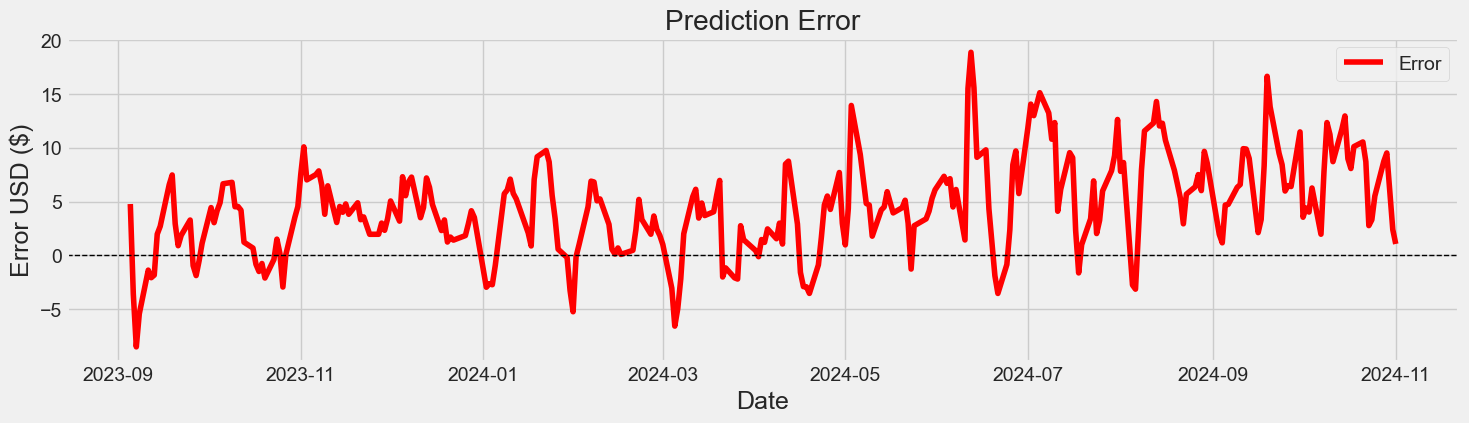

In [55]:
# Prepare valid DataFrame
valid = apple_data.iloc[training_data_len:].copy()  # Retain the original data for validation
valid['Predictions'] = predictions  # Add predictions to valid DataFrame

# Calculate error
valid['Error'] = valid['Adj Close'] - valid['Predictions']  # Assuming 'Adj Close' is the actual closing price

# Calculate Mean Absolute Error (MAE) for summary
mae = valid['Error'].abs().mean()
print(f'Mean Absolute Error: {mae}')

# PLOT
plt.figure(figsize=(16, 8))
plt.title("Model Prediction vs Actual Prices")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Plot actual vs predictions
plt.plot(apple_data['Date'][:training_data_len], apple_data['Adj Close'][:training_data_len], label='Train')
plt.plot(apple_data['Date'][training_data_len:], valid['Adj Close'], label='Actual', color='blue')
plt.plot(apple_data['Date'][training_data_len:], valid['Predictions'], label='Predictions', color='orange')
plt.legend(loc='lower right')

# Plotting the error
plt.figure(figsize=(16, 4))
plt.title("Prediction Error")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Error USD ($)', fontsize=18)
plt.plot(apple_data['Date'][training_data_len:], valid['Error'], label='Error', color='red')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a line at y=0 for reference
plt.legend(loc='upper right')
plt.show()


In [56]:
valid

company_name                      Date    Open    High     Low   Close  \
1176         AAPL 2023-09-05 00:00:00+00:00  188.28  189.98  187.61  189.70   
1177         AAPL 2023-09-06 00:00:00+00:00  188.40  188.85  181.47  182.91   
1178         AAPL 2023-09-07 00:00:00+00:00  175.18  178.21  173.54  177.56   
1179         AAPL 2023-09-08 00:00:00+00:00  178.35  180.24  177.79  178.18   
1180         AAPL 2023-09-11 00:00:00+00:00  180.07  180.30  177.34  179.36   
...           ...                       ...     ...     ...     ...     ...   
1465         AAPL 2024-10-28 00:00:00+00:00  233.32  234.73  232.55  233.40   
1466         AAPL 2024-10-29 00:00:00+00:00  233.10  234.33  232.32  233.67   
1467         AAPL 2024-10-30 00:00:00+00:00  232.61  233.47  229.55  230.10   
1468         AAPL 2024-10-31 00:00:00+00:00  229.34  229.83  225.37  225.91   
1469         AAPL 2024-11-01 00:00:00+00:00  220.96  225.34  220.28  222.91   

      Adj Close     Volume   20EMA   50SMA    RSI    VIX  Predictions  \
1176     188.73   45280000  183.48  186.77  71.39  14.01   183.955185   
1177     181.98   81755800  183.43  186.72  59.18  14.45   185.562073   
1178     176.66  112488800  182.87  186.51  54.77  14.40   185.139130   
1179     177.27   65551300  182.42  186.29  54.93  13.84   182.682114   
1180     178.45   58953100  182.13  186.09  54.72  13.80   179.809784   
...         ...        ...     ...     ...    ...    ...          ...   
1465     233.40   36087100  230.67  226.95  63.84  19.80   224.666458   
1466     233.67   35417200  230.95  227.10  58.58  19.34   224.156647   
1467     230.10   47070900  230.87  227.18  51.95  20.35   224.122101   
1468     225.91   64370100  230.40  227.17  47.25  23.16   223.507187   
1469     222.91   60699805  229.68  227.13  35.58  21.88   221.843048   

         Error  
1176  4.774815  
1177 -3.582073  
1178 -8.479130  
1179 -5.412114  
1180 -1.359784  
...        ...  
1465  8.733542  
1466  9.513353  
1467  5.977899  
1468  2.402813  
1469  1.066952  

[294 rows x 14 columns]